In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df
import datetime as dt
import pandas_bokeh

In [219]:
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend',"pandas_bokeh")

Loading BokehJS ...

In [194]:
uber = pd.read_csv('../uber_data.csv',parse_dates=["pickup_dt"])

In [195]:
uber.head()

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y


In [196]:
uber_january=uber.copy()[uber.pickup_dt<'2015-02-01 00:00:00']
uber_january

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.00,0.0,Y
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.00,0.0,Y
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.00,0.0,Y
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.00,0.0,Y
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.00,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4892,2015-01-31 23:00:00,EWR,0,7.0,10.0,24.0,1.0,1020.3,0.0,0.0,0.06,7.0,N
4893,2015-01-31 23:00:00,Manhattan,5295,7.0,10.0,24.0,1.0,1020.3,0.0,0.0,0.06,7.0,N
4894,2015-01-31 23:00:00,Queens,386,7.0,10.0,24.0,1.0,1020.3,0.0,0.0,0.06,7.0,N
4895,2015-01-31 23:00:00,Staten Island,1,7.0,10.0,24.0,1.0,1020.3,0.0,0.0,0.06,7.0,N


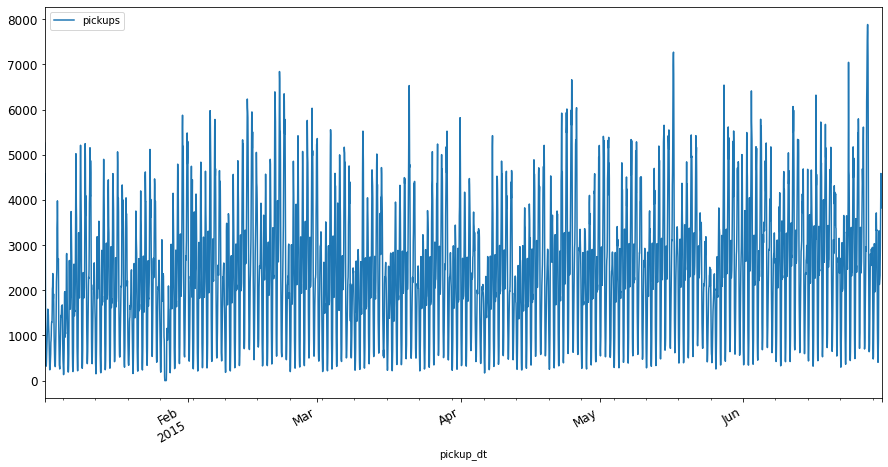

In [197]:
manhattan=uber[uber.borough=='Manhattan']
manhattan.plot(x = "pickup_dt",y=['pickups'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

In [198]:
#1month
valid_start_one_month_dt='2015-01-17 00:00:00'
test_start_one_month_dt='2015-01-24 00:00:00'

#6months
valid_start_dt = '2015-04-20 00:00:00'
test_start_dt = '2015-05-26 00:00:00'

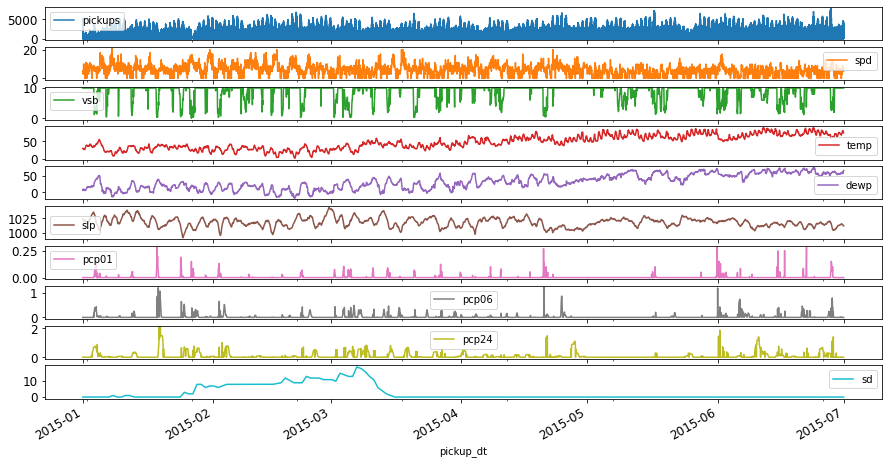

In [199]:
uber.plot(x='pickup_dt',y=['pickups','spd','vsb','temp','dewp','slp','pcp01','pcp06','pcp24','sd','hday'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

In [200]:
T = 7
HORIZON = 2

In [201]:
train = manhattan.copy()[manhattan.pickup_dt < valid_start_dt]
train=train.set_index('pickup_dt').drop(columns=['borough','hday'])

y_scaler = MinMaxScaler()
y_scaler.fit(train[['pickups',]])

X_scaler = MinMaxScaler()
train[['pickups', 'spd', 'vsb', 'temp', 'dewp', 'slp', 'pcp01', 'pcp06','pcp24', 'sd']]=X_scaler.fit_transform(train)

In [202]:
tensor_structure = {'X':(range(-T+1, 1),['pickups', 'spd', 'vsb', 'temp', 'dewp', 'slp', 'pcp01', 'pcp06','pcp24', 'sd'])}

train_inputs = TimeSeriesTensor(dataset=train,
                            target='pickups',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='H',
                            drop_incomplete=True)
train_inputs.dataframe.head(5)

tensor                 target                   X                      \
feature                     y             pickups                       
time step                 t+1       t+2       t-6       t-5       t-4   
pickup_dt                                                               
2015-01-01 07:00:00  0.048085  0.046624  0.768489  0.635048  0.668956   
2015-01-01 08:00:00  0.046624  0.061386  0.635048  0.668956  0.438907   
2015-01-01 09:00:00  0.061386  0.085647  0.668956  0.438907  0.191903   
2015-01-01 10:00:00  0.085647  0.112540  0.438907  0.191903  0.098217   
2015-01-01 11:00:00  0.112540  0.136071  0.191903  0.098217  0.062993   

tensor                                                                 ...  \
feature                                                           spd  ...   
time step                 t-3       t-2       t-1         t       t-6  ...   
pickup_dt                                                              ...   
2015-01-01 07:00:00  0.438907  0.191903  0.098217  0.062993  0.238095  ...   
2015-01-01 08:00:00  0.191903  0.098217  0.062993  0.048085  0.142857  ...   
2015-01-01 09:00:00  0.098217  0.062993  0.048085  0.046624  0.238095  ...   
2015-01-01 10:00:00  0.062993  0.048085  0.046624  0.061386  0.238095  ...   
2015-01-01 11:00:00  0.048085  0.046624  0.061386  0.085647  0.238095  ...   

tensor                                                                  
feature             pcp24             sd                                
time step             t-2  t-1    t  t-6  t-5  t-4  t-3  t-2  t-1    t  
pickup_dt                                                               
2015-01-01 07:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2015-01-01 08:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2015-01-01 09:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2015-01-01 10:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2015-01-01 11:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 72 columns]

In [203]:
X_train = train_inputs['X']
y_train = train_inputs['target']

In [204]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = manhattan.copy()[(manhattan.pickup_dt >=look_back_dt) & (uber.pickup_dt < test_start_dt)]
valid=valid.set_index('pickup_dt').drop(columns=['borough','hday'])
valid[['pickups', 'spd', 'vsb', 'temp', 'dewp', 'slp', 'pcp01', 'pcp06','pcp24', 'sd']] = X_scaler.transform(valid)

valid_inputs = TimeSeriesTensor(valid, 'pickups', HORIZON, tensor_structure)
y_valid = valid_inputs['target']
X_valid = valid_inputs['X']

<ipython-input-204-41010234499a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid = manhattan.copy()[(manhattan.pickup_dt >=look_back_dt) & (uber.pickup_dt < test_start_dt)]


In [205]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from keras import optimizers

In [206]:
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 100

In [207]:
lr = 0.001
adam = optimizers.Adam(lr)
model_lstm = Sequential()
model_lstm.add(layers.LSTM(50, activation='relu', input_shape=(T,10)))
model_lstm.add(Dense(2))
model_lstm.compile(loss='mae', optimizer=adam)
model_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                12200     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 102       
Total params: 12,302
Trainable params: 12,302
Non-trainable params: 0
_________________________________________________________________


In [208]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)

history = model_lstm.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/100
82/82 [==============================] - 1s 8ms/step - loss: 0.1596 - val_loss: 0.1505
Epoch 2/100
82/82 [==============================] - 0s 5ms/step - loss: 0.1144 - val_loss: 0.1180
Epoch 3/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0857 - val_loss: 0.0972
Epoch 4/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0793 - val_loss: 0.0848
Epoch 5/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0750 - val_loss: 0.0787
Epoch 6/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0726 - val_loss: 0.0808
Epoch 7/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0679 - val_loss: 0.0981
Epoch 8/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0655 - val_loss: 0.0696
Epoch 9/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0615 - val_loss: 0.0817
Epoch 10/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0601 - val_loss: 0.0670
Epoch 11/

Epoch 83/100
82/82 [==============================] - 1s 8ms/step - loss: 0.0360 - val_loss: 0.0470
Epoch 84/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0358 - val_loss: 0.0567
Epoch 85/100
82/82 [==============================] - 0s 4ms/step - loss: 0.0357 - val_loss: 0.0498
Epoch 86/100
82/82 [==============================] - 1s 6ms/step - loss: 0.0351 - val_loss: 0.0454
Epoch 87/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0350 - val_loss: 0.0476
Epoch 88/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0351 - val_loss: 0.0478
Epoch 89/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0344 - val_loss: 0.0488
Epoch 90/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0346 - val_loss: 0.0488
Epoch 91/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0348 - val_loss: 0.0487
Epoch 92/100
82/82 [==============================] - 0s 4ms/step - loss: 0.0349 - val_loss: 0.0491


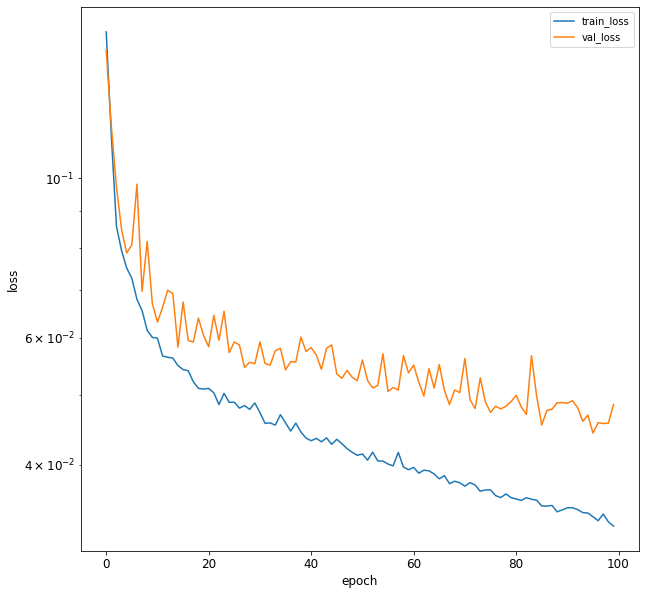

In [209]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [210]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = manhattan.copy()[manhattan.pickup_dt>test_start_dt]
test=test.set_index('pickup_dt').drop(columns=['borough','hday'])
test[['pickups', 'spd', 'vsb', 'temp', 'dewp', 'slp', 'pcp01', 'pcp06','pcp24', 'sd']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'pickups', HORIZON, tensor_structure)
X_test = test_inputs['X']
y_test = test_inputs['target']

In [211]:
predictions = model_lstm.predict(X_test)
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df

,timestamp,h,prediction,actual
0,2015-05-26 07:00:00,t+1,2398.732230,2459.0
1,2015-05-26 08:00:00,t+1,2901.552195,2742.0
2,2015-05-26 09:00:00,t+1,2305.601562,2098.0
3,2015-05-26 10:00:00,t+1,1773.665850,1861.0
4,2015-05-26 11:00:00,t+1,2050.366683,1873.0
...,...,...,...,...
1705,2015-06-30 17:00:00,t+2,3939.338548,4585.0
1706,2015-06-30 18:00:00,t+2,4351.667224,4210.0
1707,2015-06-30 19:00:00,t+2,4335.938208,4313.0
1708,2015-06-30 20:00:00,t+2,3524.616814,4452.0


In [212]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_perso(eval_df['prediction'],eval_df['actual'])

18.9188565518534

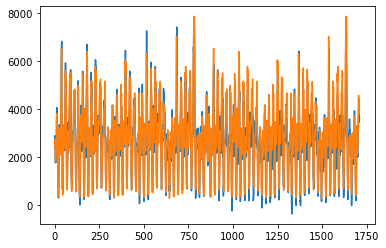

In [213]:
eval_df['prediction'].plot()
eval_df['actual'].plot()

In [ ]:
pd.concat([eval_df['prediction'],])